# Assignment nº2
## Customizing OpenAI Gym Environments and Implementing Reinforcement Learning Agents with Stable Baselines
### Introduction to Intelligent Autonomous Systems (2024/25)

##### Work assembled by Filipe Carvalho, Luana Letra and Vítor Ferreira.

## Table of contents <a name="contents"></a>
1. [Introduction](#introduction)
2. [Initial Setup](#setup)
3. [Baseline Training and Comparison](#baseline)

## 1. Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

In this notebook, we'll explore the **Walker2D baseline environment** from **Gymnasium** (formerly OpenAI Gym). The Walker2D environment features a bipedal robot that learns to walk forward. This environment uses **MuJoCo** physics simulator and provides a challenging continuous control task.

## 2. Initial Setup <a name="setup"></a>
[[go back to the top]](#contents)

First, let's import the necessary packages and create our environment. We'll examine the basic properties of the environment including its action and observation spaces.

In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
import os
from datetime import datetime
import json
import pandas as pd
import torch
import random

In [ ]:
# Create the environment
env = gym.make('Walker2d-v5')

# Reset the environment to get initial state
env.reset()

# Sample a random action from the action space
print("Sample action:", env.action_space.sample())

# Print the shape of the observation space
print("Observation space shape:", env.observation_space.shape)

# Sample a random observation from the observation space
print("Sample observation:", env.observation_space.sample())

# Close the environment
env.close()

**Sample Action**: The action space in Walker2D is continuous and consists of 6 values, each controlling different joints of the walker. Each value is in the range [-1, 1].

**Observation Space Shape**: The observation space has 17 dimensions, which include:
   - Positions and angles of various body parts
   - Velocities and angular velocities
   - Contact forces with the ground

**Sample Observation**: This shows us what a random valid state looks like. In practice, many of these random states might not be physically realistic, but they show us the range of possible values our agent might encounter.

## 3. Baseline Training and Comparison <a name="baseline"></a>
[[go back to the top]](#contents)

We started by comparing different reinforcement learning algorithms from the **Stable-Baselines3** library on the Walker2D environment from Gymnasium. We tested the following algorithms:

- **A2C** (Advantage Actor-Critic)
- **DDPG** (Deep Deterministic Policy Gradient)
- **PPO** (Proximal Policy Optimization)
- **SAC** (Soft Actor-Critic)
- **TD3** (Twin Delayed Deep Deterministic Policy Gradient)

For each algorithm, we followed this methodology:
- Train for 1 million timesteps 
- Evaluate over 100 episodes 

This controlled comparison will help us identify the best performing algorithm, which we'll then use for more extensive training (**5M timesteps**) and **environment modifications**.

In [ ]:
import os
import torch
import random
import numpy as np
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

def set_seed(seed):
    """Set all seeds for reproducibility"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

def train_model(algo_class, algo_name, seed=42):
    """
    Train a single model for 1M timesteps
    
    Args:
        algo_class: The algorithm class (A2C, PPO, etc.)
        algo_name: Name of the algorithm
        seed: Random seed for reproducibility
    """
    # Set seeds for reproducibility
    set_seed(seed)
    print(f"\nTraining {algo_name} with seed {seed}...")
    
    # Create directories for saving models
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    models_dir = f"trained_models_{timestamp}"
    os.makedirs(models_dir, exist_ok=True)
    
    # Create and seed the environment
    env = gym.make('Walker2d-v5')
    env.reset(seed=seed)
    
    # Initialize model with seed
    model = algo_class(
        'MlpPolicy', 
        env, 
        verbose=1, 
        seed=seed,
        device="auto"  # Will use GPU if available
    )
    
    try:
        # Train model
        model.learn(
            total_timesteps=1_000_000,
            progress_bar=True
        )
        
        # Save the trained model
        model_path = f"{models_dir}/{algo_name.lower()}_walker2d_1M_seed{seed}.zip"
        model.save(model_path)
        print(f"Model saved to {model_path}")
        
    except Exception as e:
        print(f"Error training {algo_name}: {str(e)}")
    
    finally:
        env.close()

def train_all_models(seed=42):
    """
    Train all algorithms with the same seed
    """
    algorithms = [
        (A2C, "A2C"),
        (DDPG, "DDPG"),
        (PPO, "PPO"),
        (SAC, "SAC"),
        (TD3, "TD3")
    ]
    
    for algo_class, algo_name in algorithms:
        train_model(algo_class, algo_name, seed=seed)

In [ ]:
train_all_models()

In [2]:
import numpy as np
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from typing import Optional, Type, Dict, List
import pandas as pd

def evaluate_walker_models(
    model_paths: Dict[str, str],
    num_episodes: int = 100,
    seed: Optional[int] = None
) -> Dict[str, Dict]:
    """
    Evaluate multiple pre-trained Walker2d models and compare their performance.
    """
    algorithms = {
        'A2C': A2C,
        'DDPG': DDPG,
        'PPO': PPO,
        'SAC': SAC,
        'TD3': TD3
    }
    
    results = {}
    
    for algo_name, model_path in model_paths.items():
        print(f"\nEvaluating {algo_name} model...")
        
        # Create evaluation environment
        eval_env = gym.make('Walker2d-v5')
        if seed is not None:
            eval_env.reset(seed=seed)
        
        # Load the trained model
        model = algorithms[algo_name].load(model_path)
        
        # Initialize storage for episode data
        episode_metrics = {
            'distances': [],
            'velocities': [],
            'episode_lengths': [],
            'completions': [],
            'total_rewards': [],
            'forward_rewards': [],
            'healthy_rewards': [],
            'ctrl_costs': []
        }
        
        for ep in range(num_episodes):
            obs, _ = eval_env.reset()
            done = False
            ep_velocity = []
            ep_length = 0
            ep_reward = 0
            ep_forward_reward = 0
            ep_healthy_reward = 0
            ep_ctrl_cost = 0
            
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                done = terminated or truncated
                
                # Update episode data
                ep_length += 1
                ep_reward += reward
                ep_velocity.append(float(info.get('x_velocity', 0)))
                
                # Track reward components
                ep_forward_reward += info.get('reward_forward', 0)
                ep_healthy_reward += info.get('reward_survive', 0)
                ep_ctrl_cost += info.get('reward_ctrl', 0)
                
                if done:
                    episode_metrics['distances'].append(float(info.get('x_position', 0)))
                    episode_metrics['velocities'].append(np.mean(ep_velocity))
                    episode_metrics['episode_lengths'].append(ep_length)
                    episode_metrics['completions'].append(truncated)
                    episode_metrics['total_rewards'].append(ep_reward)
                    episode_metrics['forward_rewards'].append(ep_forward_reward)
                    episode_metrics['healthy_rewards'].append(ep_healthy_reward)
                    episode_metrics['ctrl_costs'].append(ep_ctrl_cost)
            
            if (ep + 1) % 10 == 0:
                print(f"Completed {ep + 1}/{num_episodes} episodes")
        
        # Calculate statistics
        results[algo_name] = {
            'distance_mean': float(np.mean(episode_metrics['distances'])),
            'distance_std': float(np.std(episode_metrics['distances'])),
            'velocity_mean': float(np.mean(episode_metrics['velocities'])),
            'velocity_std': float(np.std(episode_metrics['velocities'])),
            'length_mean': float(np.mean(episode_metrics['episode_lengths'])),
            'length_std': float(np.std(episode_metrics['episode_lengths'])),
            'completion_rate': float(np.mean(episode_metrics['completions'])),
            'reward_mean': float(np.mean(episode_metrics['total_rewards'])),
            'reward_std': float(np.std(episode_metrics['total_rewards'])),
            'forward_reward_mean': float(np.mean(episode_metrics['forward_rewards'])),
            'healthy_reward_mean': float(np.mean(episode_metrics['healthy_rewards'])),
            'ctrl_cost_mean': float(np.mean(episode_metrics['ctrl_costs']))
        }
        
        eval_env.close()
    
    # Create comparison table
    comparison_data = []
    for algo_name, stats in results.items():
        comparison_data.append({
            'Algorithm': algo_name,
            'Total Reward': f"{stats['reward_mean']:.2f} ± {stats['reward_std']:.2f}",
            'Forward Reward': f"{stats['forward_reward_mean']:.2f}",
            'Healthy Reward': f"{stats['healthy_reward_mean']:.2f}",
            'Control Cost': f"{stats['ctrl_cost_mean']:.2f}",
            'Distance': f"{stats['distance_mean']:.2f} ± {stats['distance_std']:.2f}",
            'Velocity': f"{stats['velocity_mean']:.2f} ± {stats['velocity_std']:.2f}",
            'Episode Length': f"{stats['length_mean']:.2f} ± {stats['length_std']:.2f}",
            'Completion Rate': f"{stats['completion_rate']*100:.1f}%"
        })
    
    print("\nModel Comparison:")
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    return results


if __name__ == "__main__":
    model_paths = {
        'A2C': 'Models/1M/A2C_1M.zip',
        'PPO': 'Models/1M/PPO_1M.zip',
        'SAC': 'Models/1M/SAC_1M.zip',
        'TD3': 'Models/1M/TD3_1M.zip',
        'DDPG': 'Models/1M/DDPG_1M.zip',
        
    }
    
    results = evaluate_walker_models(
        model_paths=model_paths,
        num_episodes=100,
        seed=42
    )


Evaluating A2C model...
Completed 10/100 episodes
Completed 20/100 episodes
Completed 30/100 episodes
Completed 40/100 episodes
Completed 50/100 episodes
Completed 60/100 episodes
Completed 70/100 episodes
Completed 80/100 episodes
Completed 90/100 episodes
Completed 100/100 episodes

Evaluating PPO model...
Completed 10/100 episodes
Completed 20/100 episodes
Completed 30/100 episodes
Completed 40/100 episodes
Completed 50/100 episodes
Completed 60/100 episodes
Completed 70/100 episodes
Completed 80/100 episodes
Completed 90/100 episodes
Completed 100/100 episodes

Evaluating SAC model...
Completed 10/100 episodes
Completed 20/100 episodes
Completed 30/100 episodes
Completed 40/100 episodes
Completed 50/100 episodes
Completed 60/100 episodes
Completed 70/100 episodes
Completed 80/100 episodes
Completed 90/100 episodes
Completed 100/100 episodes

Evaluating TD3 model...
Completed 10/100 episodes
Completed 20/100 episodes
Completed 30/100 episodes
Completed 40/100 episodes
Completed 50/

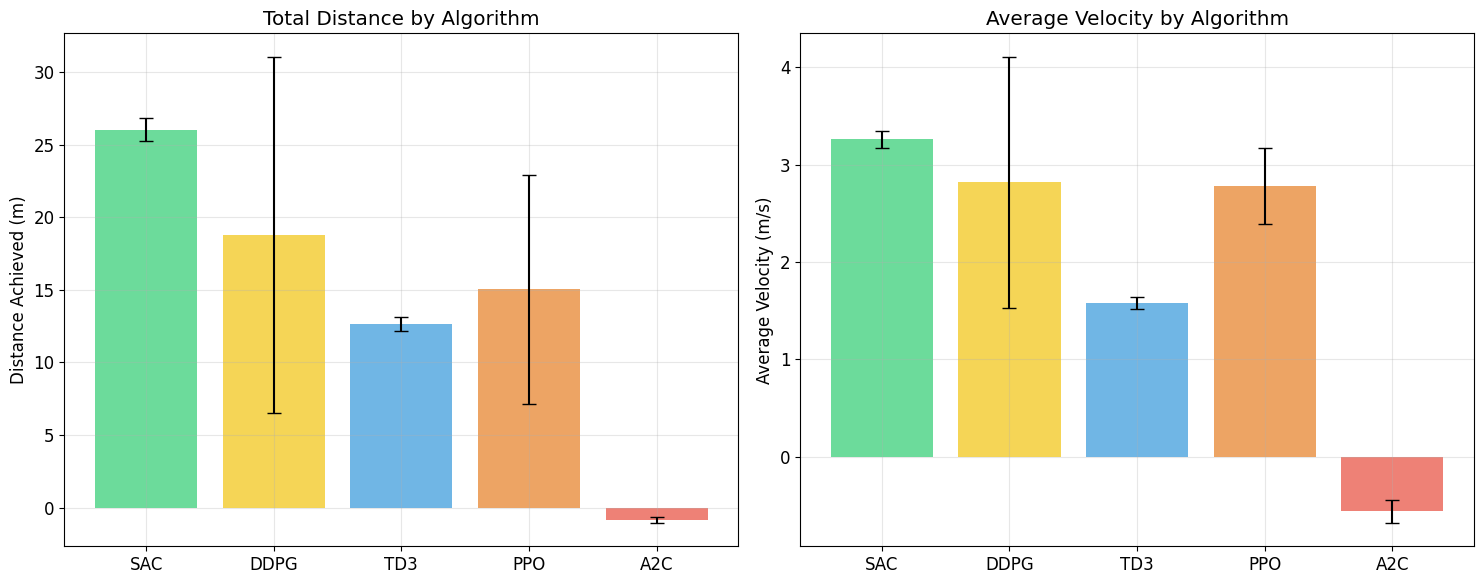

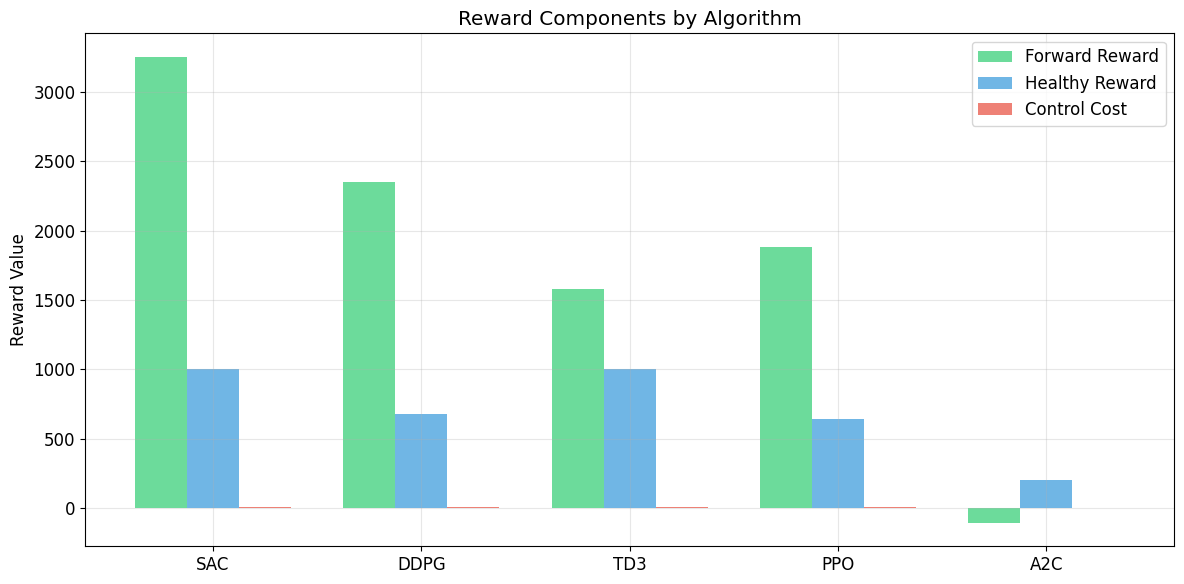

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def create_performance_plots(results_data):
    # Prepare data
    algorithms = ['SAC', 'DDPG', 'TD3', 'PPO', 'A2C']
    distances = [26.05, 18.81, 12.66, 15.03, -0.87]
    distance_stds = [0.76, 12.26, 0.47, 7.88, 0.19]
    velocities = [3.26, 2.82, 1.58, 2.78, -0.56]
    velocity_stds = [0.09, 1.29, 0.06, 0.39, 0.12]
    
    # Reward components data
    forward_rewards = [3256.18, 2351.02, 1582.60, 1879.30, -109.26]
    healthy_rewards = [1000.00, 675.08, 1000.00, 640.47, 201.68]
    control_costs = [-3.03, -4.05, -4.30, -2.58, -1.22]
    
    # Set style for presentation
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 12
    
    # Figure 1: Distance and Velocity Comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    x = np.arange(len(algorithms))
    colors = ['#2ecc71', '#f1c40f', '#3498db', '#e67e22', '#e74c3c']
    
    # Distance plot
    ax1.bar(x, distances, yerr=distance_stds, capsize=5, color=colors, alpha=0.7)
    ax1.set_ylabel('Distance Achieved (m)')
    ax1.set_title('Total Distance by Algorithm')
    ax1.set_xticks(x)
    ax1.set_xticklabels(algorithms, rotation=0)
    ax1.grid(True, alpha=0.3)
    
    # Velocity plot
    ax2.bar(x, velocities, yerr=velocity_stds, capsize=5, color=colors, alpha=0.7)
    ax2.set_ylabel('Average Velocity (m/s)')
    ax2.set_title('Average Velocity by Algorithm')
    ax2.set_xticks(x)
    ax2.set_xticklabels(algorithms, rotation=0)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Figure 2: Reward Components
    fig2, ax = plt.subplots(figsize=(12, 6))
    width = 0.25
    
    # Plot bars for each reward component
    ax.bar(x - width, forward_rewards, width, label='Forward Reward', color='#2ecc71', alpha=0.7)
    ax.bar(x, healthy_rewards, width, label='Healthy Reward', color='#3498db', alpha=0.7)
    ax.bar(x + width, np.abs(control_costs), width, label='Control Cost', color='#e74c3c', alpha=0.7)
    
    # Customize appearance
    ax.set_ylabel('Reward Value')
    ax.set_title('Reward Components by Algorithm')
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    plt.show()

create_performance_plots({})

**SAC (Soft Actor-Critic)** emerged as the clear winner across all metrics:
- Achieved the highest total reward (4253.14) with remarkable consistency (± 94.81)
- Reached maximum forward progress (3256.18 forward reward) and distance (26.05m)
- Maintained the highest average velocity (3.26 m/s)
- Perfect completion rate (100%) with maximum episode length
- Balanced performance with moderate control cost (-3.03)

**TD3 (Twin Delayed DDPG)** showed strong stability but lower performance:
- Perfect completion rate (100%) matching SAC
- Lower total reward (2578.30) but very consistent (± 58.74)
- More conservative movement with lowest velocity (1.58 m/s)
- Highest control cost (-4.30) suggesting less efficient movement

**DDPG** and **PPO** formed a middle tier with mixed results:
- DDPG: Higher mean reward (3022.05) but extremely inconsistent (± 1899.62)
- PPO: Similar performance to TD3 but less stable
- Both achieved decent velocities (~2.8 m/s) but lower completion rates (47% and 29%)

**A2C** significantly underperformed:
- Negative forward progress (-0.87m distance, -0.56 m/s velocity)
- Minimal total reward (91.20)
- Zero completion rate
- Shortest episode lengths (202.68 steps)
- Even its low control cost (-1.22) indicates ineffective learning

The results suggest that SAC's entropy-based approach and sample efficiency make it particularly well-suited for this continuous control task, while A2C's simpler architecture struggles with the environment's complexity.

Then, we proceeded to train the agent with SAC for 5M timesteps.

In [3]:
import numpy as np
import json
import gymnasium as gym
from datetime import datetime
import os
from stable_baselines3 import SAC
from typing import Optional, Type

def evaluate_walker_model(
    model_path: str,
    num_episodes: int = 100,
    seed: Optional[int] = None
) -> dict:
    """
    Evaluate a pre-trained Walker2d model focusing on distance achieved and velocity maintained.
    """
    # Create evaluation environment
    eval_env = gym.make('Walker2d-v5')
    if seed is not None:
        eval_env.reset(seed=seed)
    
    # Load the trained model
    model = SAC.load(model_path)
    
    # Initialize storage for episode data
    episode_data = []
    
    for ep in range(num_episodes):
        obs, _ = eval_env.reset()
        done = False
        ep_data = {
            'episode_length': 0,
            'velocities': [],
            'terminated': False,
            'truncated': False
        }
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            
            # Update episode data
            ep_data['episode_length'] += 1
            ep_data['velocities'].append(float(info.get('x_velocity', 0)))
            if done:  # Store final position when episode ends
                ep_data['final_position'] = float(info.get('x_position', 0))
            ep_data['terminated'] = terminated
            ep_data['truncated'] = truncated
        
        # Calculate episode statistics
        avg_velocity = np.mean(ep_data['velocities'])
        ep_stats = {
            'episode': ep + 1,
            'episode_length': ep_data['episode_length'],
            'distance': ep_data['final_position'],
            'avg_velocity': avg_velocity,
            'reached_max_steps': ep_data['truncated']
        }
        
        episode_data.append(ep_stats)
        print(f"Episode {ep + 1}: "
              f"Length = {ep_stats['episode_length']}, "
              f"Position = {ep_stats['distance']:.2f}, "  
              f"Avg Velocity = {ep_stats['avg_velocity']:.2f}, "
              f"{'Completed' if ep_stats['reached_max_steps'] else 'Terminated'}")
    
    # Calculate overall statistics
    completion_rate = sum(1 for ep in episode_data if ep['reached_max_steps']) / num_episodes
    avg_distance = np.mean([ep['distance'] for ep in episode_data])
    std_distance = np.std([ep['distance'] for ep in episode_data])
    avg_velocity = np.mean([ep['avg_velocity'] for ep in episode_data])
    std_velocity = np.std([ep['avg_velocity'] for ep in episode_data])
    
    # Compile results
    results = {
        'completion_rate': float(completion_rate),
        'average_position': float(avg_distance),
        'position_std': float(std_distance),
        'average_velocity': float(avg_velocity),
        'velocity_std': float(std_velocity),
        'num_episodes': num_episodes,
        'evaluation_seed': seed,
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'episode_details': episode_data
    }
    
    # Print summary
    print("\nEvaluation Results:")
    print(f"Completion Rate: {completion_rate*100:.1f}%")
    print(f"Average Position: {avg_distance:.2f} ± {std_distance:.2f}")
    print(f"Average Velocity: {avg_velocity:.2f} ± {std_velocity:.2f}")
    
    # Save results
    os.makedirs("evaluation_results", exist_ok=True)
    results_path = f"evaluation_results/eval_{results['timestamp']}.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    
    eval_env.close()
    return results

In [6]:
results = evaluate_walker_model(
    model_path="Models/5M/SAC_Baseline_5M",
    num_episodes=100,
    seed=42  
)

Episode 1: Length = 197, Position = 1.81, Avg Velocity = 1.15, Terminated
Episode 2: Length = 112, Position = 0.14, Avg Velocity = 0.16, Terminated
Episode 3: Length = 181, Position = 1.54, Avg Velocity = 1.06, Terminated
Episode 4: Length = 234, Position = 2.72, Avg Velocity = 1.45, Terminated
Episode 5: Length = 149, Position = 0.75, Avg Velocity = 0.63, Terminated
Episode 6: Length = 161, Position = 0.83, Avg Velocity = 0.65, Terminated
Episode 7: Length = 171, Position = 1.08, Avg Velocity = 0.79, Terminated
Episode 8: Length = 219, Position = 1.63, Avg Velocity = 0.93, Terminated
Episode 9: Length = 155, Position = 0.84, Avg Velocity = 0.68, Terminated
Episode 10: Length = 142, Position = 1.11, Avg Velocity = 0.97, Terminated
Episode 11: Length = 113, Position = 0.15, Avg Velocity = 0.17, Terminated
Episode 12: Length = 172, Position = 1.03, Avg Velocity = 0.75, Terminated
Episode 13: Length = 158, Position = 0.81, Avg Velocity = 0.64, Terminated
Episode 14: Length = 1000, Positio

The large standard deviations and low completion rate suggest the policy became unstable. 

To address this, we implemented a learning rate scheduler that gradually decreases as training progresses.

In [ ]:
import os
import torch
import numpy as np
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

# Learning rate scheduler callback
class LearningRateScheduler(BaseCallback):
    def __init__(self, initial_learning_rate=3e-4, min_learning_rate=1e-5):
        super().__init__()
        self.initial_lr = initial_learning_rate
        self.min_lr = min_learning_rate
        
    def _on_step(self):
        progress_fraction = self.num_timesteps / 5_000_000
        new_lr = max(
            self.min_lr,
            self.initial_lr * (1 - progress_fraction)
        )
        
        # Update only actor and critic optimizers
        self.model.actor.optimizer.param_groups[0]['lr'] = new_lr
        self.model.critic.optimizer.param_groups[0]['lr'] = new_lr
        return True

# Create directories
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"results/SAC_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

# Create environment and model
env = gym.make('Walker2d-v5')
model = SAC(
    'MlpPolicy',
    env,
    tensorboard_log=f"{results_dir}/tb_logs",
    verbose=1
)

# Create scheduler and train
lr_scheduler = LearningRateScheduler()
model.learn(
    total_timesteps=5_000_000,
    callback=lr_scheduler,
    progress_bar=True
)

# Save model
model.save(f"{results_dir}/final_model")
print(f"Training completed. Model saved in {results_dir}")
env.close()

As we can see below, the results improved a lot and the agent became more stable.

In [7]:
results = evaluate_walker_model(
    model_path="Models/5M/SAC_Baseline_5M_LR",
    num_episodes=100,
    seed=42  
)

Episode 1: Length = 1000, Position = 35.75, Avg Velocity = 4.47, Completed
Episode 2: Length = 1000, Position = 35.39, Avg Velocity = 4.42, Completed
Episode 3: Length = 219, Position = 4.96, Avg Velocity = 2.83, Terminated
Episode 4: Length = 1000, Position = 35.15, Avg Velocity = 4.39, Completed
Episode 5: Length = 1000, Position = 35.32, Avg Velocity = 4.42, Completed
Episode 6: Length = 1000, Position = 34.65, Avg Velocity = 4.33, Completed
Episode 7: Length = 1000, Position = 35.75, Avg Velocity = 4.47, Completed
Episode 8: Length = 1000, Position = 35.28, Avg Velocity = 4.41, Completed
Episode 9: Length = 1000, Position = 35.59, Avg Velocity = 4.45, Completed
Episode 10: Length = 1000, Position = 34.77, Avg Velocity = 4.35, Completed
Episode 11: Length = 1000, Position = 35.30, Avg Velocity = 4.41, Completed
Episode 12: Length = 1000, Position = 34.76, Avg Velocity = 4.34, Completed
Episode 13: Length = 1000, Position = 34.82, Avg Velocity = 4.35, Completed
Episode 14: Length = 1